In [1]:
import tensorflow as tf

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

2022-01-24 03:03:20.306052: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-24 03:03:20.306082: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


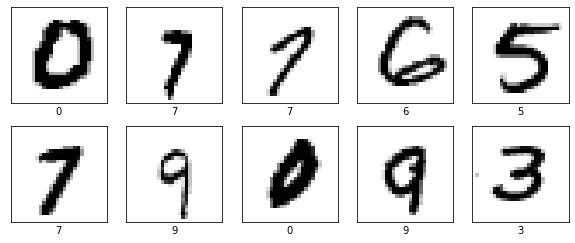

In [2]:
from simple_deep_learning.mnist_extended.mnist import display_digits

display_digits(images=train_images, labels=train_labels, num_to_display=10)

### Dataset

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from simple_deep_learning.mnist_extended.semantic_segmentation import (create_semantic_segmentation_dataset, display_segmented_image,
                                                                       display_grayscale_array, plot_class_masks)

In [4]:
np.random.seed(seed=9)
train_x, train_y, test_x, test_y = create_semantic_segmentation_dataset(num_train_samples=1000,
                                                                        num_test_samples=300,
                                                                        image_shape=(64, 64),
                                                                        min_num_digits_per_image=3,
                                                                        max_num_digits_per_image=3,
                                                                        num_classes=7)

In [5]:
i = np.random.randint(len(train_x))
print(len(train_x))
print(train_x[i].shape)
print(train_y[i].shape)

1000
(64, 64, 1)
(64, 64, 7)


In [6]:
np.save('/home/e_radionova/Datasets/MNIST_multiclass/7classes_3per-image/train_x.npy', train_x)
np.save('/home/e_radionova/Datasets/MNIST_multiclass/7classes_3per-image/train_y.npy', train_y)
np.save('/home/e_radionova/Datasets/MNIST_multiclass/7classes_3per-image/test_x.npy', test_x)
np.save('/home/e_radionova/Datasets/MNIST_multiclass/7classes_3per-image/test_y.npy', test_y)

In [4]:

# for i in range(20):
#     plt.imshow(train_x[i])
#     plt.show()
#     display_segmented_image(y=train_y[i])
#     f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
#     ax1.imshow(train_y[i][:,:,0])
#     ax2.imshow(train_y[i][:,:,1])
#     ax3.imshow(train_y[i][:,:,2])
#     plt.show()

In [50]:
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from torchvision import transforms
import random
from torchvision.transforms import ToTensor
import torch

In [89]:
class MNISTMulticlassDataset(Dataset):
    def __init__(self, images_folder, masks_folder, 
                 transform=None):
        super(Dataset, self).__init__()
        
        self.images_folder = images_folder
        self.masks_folder = masks_folder

        self.images_names = np.load((self.images_folder))
        self.masks_names = np.load((self.masks_folder))
        
        self.to_tensor = ToTensor()
        self.transform = transform

    def __len__(self):
        return len(self.images_names)
    
    def __getitem__(self, idx):
        item_image = self.images_names[idx]
        item_mask = self.masks_names[idx]
        
        if self.transform is not None:
            transformed = self.transform(image=item_image, mask=item_mask)
            item_image = transformed["image"]
            item_mask = transformed["mask"]

        item_image = self.to_tensor(item_image.copy())
        item_mask = self.to_tensor(item_mask.copy())

        return item_image, item_mask

In [90]:
dataset_path = Path('/home/e_radionova/Datasets/MNIST_multiclass/3classes_3per-image')

In [91]:
trans = None
# transforms.Compose([
#     transforms.ToTensor(),
# ])

train_set = MNISTMulticlassDataset(images_folder = dataset_path / 'train_x.npy', 
                         masks_folder = dataset_path / 'train_y.npy',
                         transform = trans)

val_set = MNISTMulticlassDataset(images_folder = dataset_path / 'test_x.npy', 
                         masks_folder = dataset_path / 'test_y.npy',
                         transform = trans)

In [95]:
image_datasets = {
    'train': train_set , 'val': val_set
}

batch_size_train = 8
batch_size_val = batch_size_train

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size_train, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size_val, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 500, 'val': 100}

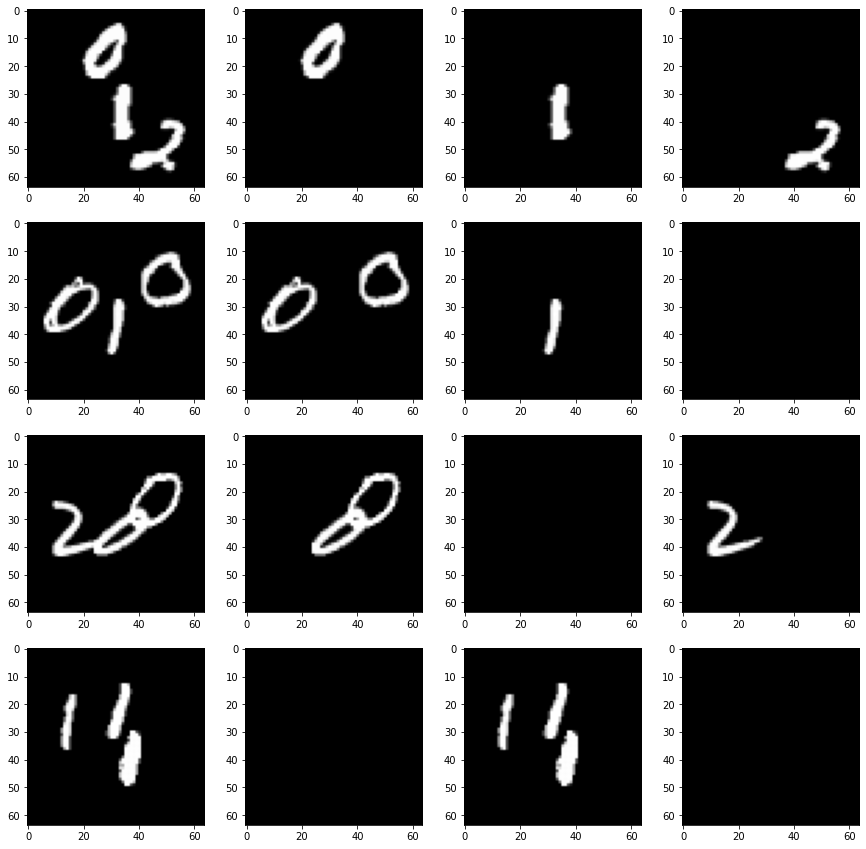

In [100]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

n_pics_to_show = 4
inputs, masks = next(iter(dataloaders['train']))
fig, ax = plt.subplots(n_pics_to_show, 4, figsize=(15, 15))
for i in range(n_pics_to_show):
    pic, label = inputs[i], masks[i]
    label_np = label.data.numpy().transpose(1, 2, 0)
    pic_np = pic.data.numpy().transpose(1, 2, 0)
    ax[i,0].imshow(pic_np, cmap='gray')
    ax[i,1].imshow(label_np[:,:,0], cmap='gray')
    ax[i,2].imshow(label_np[:,:,1], cmap='gray')
    ax[i,3].imshow(label_np[:,:,2], cmap='gray')